# ロジスティック回帰モデルによる値動きの予測（ブログ用）

In [1]:
# ライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from datetime import date, datetime, timedelta
import talib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## オシレーター指標関数の定義

In [2]:
# function Elder's Force Index (EFI)
def elder_force_index(df, period=2):
    df['EFI'] = (df['Close'] - df['Close'].shift(1)) * df['Volume']
    df['EFI_Smoothed'] = df['EFI'].rolling(window=period).mean()
    return df['EFI_Smoothed']

## パフォーマンス評価関数の定義

In [3]:
def evaluate_performance(data):
    cumulative_return = data['Portfolio_Value'].iloc[-1] / data['Portfolio_Value'].iloc[0] - 1
    volatility = data['Strategy_Returns'].std() * (252**0.5)
    sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * (252**0.5)
    return {
        "Cumulative Return": cumulative_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

## 株価データの読み込み

In [4]:
# Download data
ticker = '9984.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
data = yf.download(ticker, start_date, end_date)
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data.index = pd.to_datetime(data.index)

[*********************100%***********************]  1 of 1 completed


## 特徴量（説明変数）の生成

In [5]:
# 特徴量候補となる指標値の計算 
data['SMA50'] = data['Close'].rolling(window=50).mean() 
data['SMA200'] = data['Close'].rolling(window=200).mean() 
data['Volatility'] = data['Close'].rolling(window=20).std() 
data['Daily Return'] = data['Close'].pct_change() 
data['EFI'] = elder_force_index(data)
data['MACD'], data['MACD_signal'], data['MACD_hist'] = talib.MACD(data['Close'], \
        fastperiod=12, slowperiod=26, signalperiod=9)
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['fastk'], data['fastd'] = talib.STOCHF(data['High'], data['Low'], data['Close'],\
                            fastk_period=5, fastd_period=3, fastd_matype=0)
data['OBV'] = talib.OBV(data['Close'], data['Volume'])

## 目的変数の生成

In [6]:
# Remove NaN rows 
data = data.dropna().reset_index()
# Create binary target label for prediction
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

## 特徴量の指定とモデルの初期設定

In [7]:
# Select features and target
features = ['SMA200','MACD','EFI','RSI','OBV','fastd','Volatility']
X = data[features]
y = data['Target']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## モデルの生成と学習

In [8]:
# Create and train the model
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [9]:
# Evaluate the model
y_pred = model.predict(X_test)  
print("Accuracy:", accuracy_score(y_test, y_pred))  

Accuracy: 0.6666666666666666


In [10]:
new_data = X.tail(1)
prediction = model.predict(new_data)  
print("Prediction:", prediction)

Prediction: [0]


In [11]:
# Get probability predictions
probabilities = model.predict_proba(new_data)
# Print the first few probability predictions
print(probabilities)

[[0.60510484 0.39489516]]


## ポジションとリターン

In [12]:
# Add predictions to the test DataFrame
data['Predicted_Signal'] = model.predict(X) * 2 - 1
# Create the trading position: 1 for buy, -1 for sell
data['Position'] = data['Predicted_Signal'].shift()
# Calculate strategy returns
data['Strategy_Returns'] = data['Position'] * data['Daily Return']
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod() - 1
data['Cumulative_Market_Returns'] = (1 + data['Daily Return']).cumprod() - 1

## バックテスト

In [13]:
initial_balance = 10000
df = data.copy()
df['Portfolio_Value'] = (1 + df['Strategy_Returns']).cumprod() * initial_balance
df.at[df.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(df)
print(ticker[0]  + '  Performance')
print(performance)

9  Performance
{'Cumulative Return': 0.25119135637050793, 'Volatility': 0.4601680385032216, 'Sharpe Ratio': 3.090126271376685}


## パフォーマンスの図示

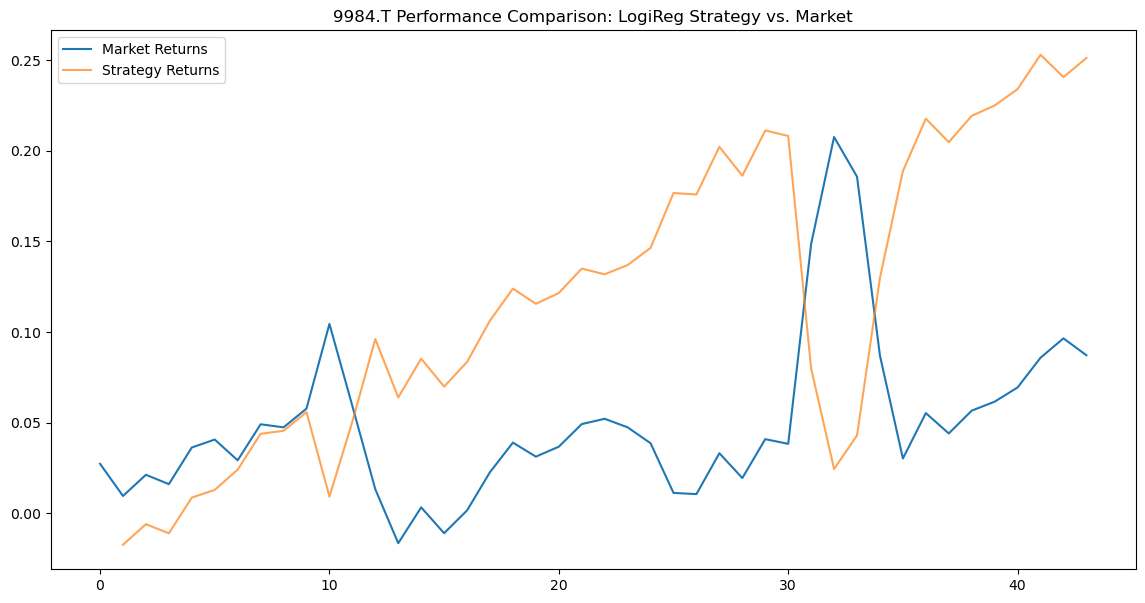

In [14]:
plt.figure(figsize=(14,7))
plt.plot(data['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Returns', alpha=0.7)
plt.legend(loc='upper left')
plt.title(ticker+' Performance Comparison: LogiReg Strategy vs. Market')
plt.show()